# Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 2
param_num = 4
degree = 1

In [2]:
assert testcase == 1 and version in [1,2]
assert param_num <= 4
assert degree <= 3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem_1_1D import FEMSolver
from modules.utils import create_tree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using device: cpu


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
if version == 1:
    from modules.testcases.d1.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
elif version == 2:
    from modules.testcases.d1.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
from modules.problem_1D import TestCase1
problem = TestCase1()

result_dir = "../../results/1D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cpu


init
Training PINN
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe1_v2.pth
network loaded
Error  tensor([0.0436])


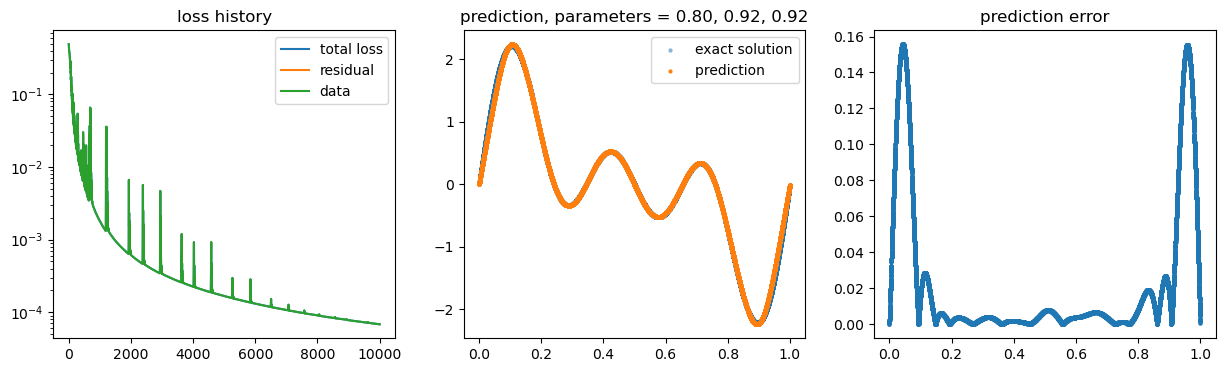

In [6]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

In [7]:
test_params = [[0.3, 0.2, 0.1], [0.4, 0.6, 0.3], [0.7, 0.4, 0.6], [0.8, 0.5, 0.8]]
param = test_params[param_num-1]
print(f"param_num = {param_num}, param = {param}")
params = [param]

param_num = 4, param = [0.8, 0.5, 0.8]


## Convergence FEM

In [8]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [9]:
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

hmax =  0.06666666666666676
nb_vert=16, norme_L2=0.09417328818027348
hmax =  0.032258064516129115
nb_vert=32, norme_L2=0.022610714102477638
hmax =  0.015873015873015928
nb_vert=64, norme_L2=0.005506592531680129
hmax =  0.007874015748031593
nb_vert=128, norme_L2=0.0013569530065524534
hmax =  0.0039215686274510775
nb_vert=256, norme_L2=0.00033669847383631927


## Convergence PINNs+Corr

In [10]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [11]:
degree_PINNs = 10

def read_csv_Corr_Add(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr_Add(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr_Add(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            V_test,X_test,mu_test = get_test_sample(0,solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [12]:
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr_Add(degree)

hmax =  0.06666666666666676
nb_vert=16, norme_L2=0.0022814560563733243
hmax =  0.032258064516129115
nb_vert=32, norme_L2=0.0007492078159889487
hmax =  0.015873015873015928
nb_vert=64, norme_L2=0.00020856693070961708
hmax =  0.007874015748031593
nb_vert=128, norme_L2=5.295980505895847e-05
hmax =  0.0039215686274510775
nb_vert=256, norme_L2=1.3236095346174291e-05


In [13]:
degree_PINNs = 10

def read_csv_Corr_Mult(testcase,param_num,degree,M):
    df_Mult = pd.read_csv(result_dir+f'Mult_case{testcase}_param{param_num}_degree{degree}_M{M}.csv')
    tab_nb_vert_Mult = list(df_Mult['nb_vert'].values)
    tab_h_Mult = list(df_Mult['h'].values)
    tab_err_Mult = list(df_Mult['err'].values)
    
    return df_Mult,tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult

def run_Corr_Mult(degree,M=0.0,new_run=False):
    csv_file = result_dir+f'Mult_case{testcase}_param{param_num}_degree{degree}_M{M}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Mult,tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult = read_csv_Corr_Mult(testcase,param_num,degree,M)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Mult = [2**i for i in range(4,9)]
        tab_h_Mult = []
        tab_err_Mult = []

        for nb_vert in tab_nb_vert_Mult:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Mult.append(solver.h)
            
            V_test,X_test,mu_test = get_test_sample(0,solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            _,_,norme_L2 = solver.corr_mult(0,u_PINNs,M=M)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Mult.append(norme_L2)
            
        df_Mult = pd.DataFrame({'nb_vert': tab_nb_vert_Mult, 'h': tab_h_Mult, 'err': tab_err_Mult})
        df_Mult.to_csv(csv_file, index=False)
            
    return df_Mult,tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult

In [14]:
M = 3.0
df_Mult3,tab_nb_vert_Mult3, tab_h_Mult3, tab_err_Mult3 = run_Corr_Mult(degree,M=M)

hmax =  0.06666666666666676
nb_vert=16, norme_L2=0.0022295097385038824
hmax =  0.032258064516129115
nb_vert=32, norme_L2=0.0007686518270379274
hmax =  0.015873015873015928
nb_vert=64, norme_L2=0.00021674117350230283
hmax =  0.007874015748031593
nb_vert=128, norme_L2=5.5287183797963083e-05
hmax =  0.0039215686274510775
nb_vert=256, norme_L2=1.3834155568550395e-05


In [15]:
M = 100.0
df_Mult100,tab_nb_vert_Mult100, tab_h_Mult100, tab_err_Mult100 = run_Corr_Mult(degree,M=M)

hmax =  0.06666666666666676
nb_vert=16, norme_L2=0.0022810608722735035
hmax =  0.032258064516129115
nb_vert=32, norme_L2=0.0007500140828678534
hmax =  0.015873015873015928
nb_vert=64, norme_L2=0.0002088404612760711
hmax =  0.007874015748031593
nb_vert=128, norme_L2=5.303301572970201e-05
hmax =  0.0039215686274510775
nb_vert=256, norme_L2=1.3254625475873872e-05


## Facteurs

In [16]:
tab_err_FEM = np.array(tab_err_FEM)
tab_err_Corr = np.array(tab_err_Corr)
tab_err_Mult3 = np.array(tab_err_Mult3)
tab_err_Mult100 = np.array(tab_err_Mult100)

facteurs_Add = tab_err_FEM/tab_err_Corr
print(facteurs_Add)
facteurs_Mult3 = tab_err_FEM/tab_err_Mult3
print(facteurs_Mult3)
facteurs_Mult100 = tab_err_FEM/tab_err_Mult100
print(facteurs_Mult100)

[41.27771294 30.17949576 26.4020404  25.62231876 25.4379003 ]
[42.23946034 29.4160676  25.40630579 24.54371725 24.33820208]
[41.28486413 30.14705273 26.36746011 25.58694783 25.40233781]


## Plots

Read csv file ../../results/1D/testcase1/version2/cvg/FEM_case1_param4_degree1.csv
Read csv file ../../results/1D/testcase1/version2/cvg/Corr_case1_param4_degree1.csv
Read csv file ../../results/1D/testcase1/version2/cvg/Mult_case1_param4_degree1_M3.0.csv
Read csv file ../../results/1D/testcase1/version2/cvg/Mult_case1_param4_degree1_M100.0.csv


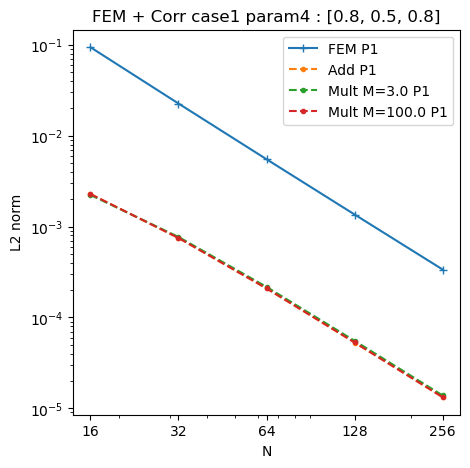

In [17]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)
plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(degree))

# plot Corr error (L2 norm) as a function of h
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr_Add(degree)
plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Add P'+str(degree))

# plot Corr error (L2 norm) as a function of h
df_Mult3,tab_nb_vert_Mult3, tab_h_Mult3, tab_err_Mult3 = run_Corr_Mult(degree,M=3.0)
plt.loglog(df_Mult3['nb_vert'], df_Mult3['err'], ".--", label='Mult M=3.0 P'+str(degree))

# plot Corr error (L2 norm) as a function of h
df_Mult100,tab_nb_vert_Mult100, tab_h_Mult100, tab_err_Mult100 = run_Corr_Mult(degree,M=100.0)
plt.loglog(df_Mult100['nb_vert'], df_Mult100['err'], ".--", label='Mult M=100.0 P'+str(degree))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')

In [18]:
# dataframe : classic, add, mult3, mult100
# error and facteurs, error and facteurs, error and facteurs, error and facteurs
# multiindex : error, facteurs

import pandas as pd

val = [tab_err_FEM, tab_err_Corr, facteurs_Add, tab_err_Mult3, facteurs_Mult3, tab_err_Mult100, facteurs_Mult100]

iterables = [("FEM","error"), ("Corr","error"), ("Corr","facteurs"), ("Mult3","error"), ("Mult3","facteurs"), ("Mult100","error"), ("Mult100","facteurs")]
index = pd.MultiIndex.from_tuples(iterables, names=["method", "type"])

df = pd.DataFrame(val, index=index, columns=tab_nb_vert_FEM).T

# Appliquer des formats spécifiques en fonction du type
def custom_formatting(df):
    # Appliquer un format spécifique pour les erreurs (notation scientifique)
    error_cols = df.columns[df.columns.get_level_values('type') == 'error']
    df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
    
    # Arrondir les facteurs à l'entier le plus proche
    factor_cols = df.columns[df.columns.get_level_values('type') == 'facteurs']
    df[factor_cols] = df[factor_cols].applymap(lambda x: f'{int(round(x))}')

    return df

# Appliquer la fonction de mise en forme
formatted_df = custom_formatting(df)

# Sauvegarder le DataFrame formaté au format CSV
formatted_df.to_csv(result_dir+f'Tab_case{testcase}_version{version}_param{param_num}_degree{degree}.csv')
# Et au format PNG
import dataframe_image as dfi
dfi.export(formatted_df, result_dir+f'Tab_case{testcase}_version{version}_param{param_num}_degree{degree}.png', dpi=300)

# Afficher le DataFrame formaté
formatted_df

/tmp/ipykernel_1696829/959267673.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/tmp/ipykernel_1696829/959267673.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{int(round(x))}')


method       FEM      Corr              Mult3            Mult100         
type       error     error facteurs     error facteurs     error facteurs
16      9.42e-02  2.28e-03       41  2.23e-03       42  2.28e-03       41
32      2.26e-02  7.49e-04       30  7.69e-04       29  7.50e-04       30
64      5.51e-03  2.09e-04       26  2.17e-04       25  2.09e-04       26
128     1.36e-03  5.30e-05       26  5.53e-05       25  5.30e-05       26
256     3.37e-04  1.32e-05       25  1.38e-05       24  1.33e-05       25